# Import necessary libraries

- Numpy for generating arrays
- Pandas for working with dataframes
- Request for reaching the weather API
- Datetime for working with date and time and its conversion
- JSON package to work with json files which are provided by the weather API
- Folium to plot maps
- seaborn and matplotlib to plot other graphics
- different sklearn packages to build models and find correlations between the data or predict labels


In [1]:
!pip install folium
!pip install kmodes

from project_lib import Project
import numpy as np
import pandas as pd
import requests
import datetime
from pandas.io.json import json_normalize, json
import folium
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from kmodes.kmodes import KModes
from sklearn.tree import DecisionTreeClassifier

     |████████████████████████████████| 92kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 22.0MB/s eta 0:00:01


Initializing of project token to read data from IBM object storage and read weather API
The hidden_cell feature is used to keep the data safe

In [2]:
# The code was removed by Watson Studio for sharing.

The next part is about requesting data from the weather API
- definition of output table
- definition of start and end data for data collection
- as long as the start date is smaller than the end date a query is build and sent to the server; the result is appended to a result dataframe
- save complete result dataframe to object storage as API has a rate limit and could only be called 500 times per day

In [ ]:
header_column_list = ['astronomy', 'avgtempC', 'avgtempF', 'date', 'hourly', 'maxtempC', 'maxtempF', 'mintempC', 'mintempF', 'sunHour', 'totalSnow_cm', 'uvIndex']
df_result_nyc = pd.DataFrame(columns=header_column_list)
df_result_tokyo = pd.DataFrame(columns=header_column_list)
    
start_date = datetime.date(2012, 4, 1)
end_date = datetime.date(2013, 2, 20)
from_date = start_date
    
while from_date < end_date:
    to_date = from_date + datetime.timedelta(days=31)
    #print(str(previous) + ' - ' + str(date))
    #print('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=ec64962692ca48399ce223327201804&q=New York&format=json&date={start_date}&enddate={end_date}&tp=1'.format(start_date=str(previous), end_date=str(date)))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=New York&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_nyc = df_result_nyc.append(pd.DataFrame(result.json()['data']['weather']))
    result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={key}&q=Tokyo&format=json&extra=utcDateTime&date={from_date}&enddate={to_date}&tp=1'.format(key= weatheronline_api_key, from_date=str(from_date), to_date=str(to_date)))
    df_result_tokyo = df_result_tokyo.append(pd.DataFrame(result.json()['data']['weather']))
    from_date = to_date + datetime.timedelta(days=1)
project.save_data("weather_nyc.csv", df_result_nyc.to_csv(index=False), overwrite=True)
project.save_data("weather_tokyo.csv", df_result_tokyo.to_csv(index=False), overwrite=True)

data (weather as well as check-in data) is imported from object storage
The Tokyo data is currently commented as it is not used. However, in future it is planned to compare the check-ins between New York and Tokyo.
For the hourly column which is formatted as JSON the doublequotes are replaced by simple quotes to be in line with the official style guide for json files

In [3]:
df_nyc = pd.read_csv(project.get_file('dataset_TSMC2014_NYC.csv'))
#df_tokyo = pd.read_csv(project.get_file('dataset_TSMC2014_TKY.csv'))

df_nyc_weather = pd.read_csv(project.get_file('weather_nyc.csv'))
#df_tokyo_weather = pd.read_csv(project.get_file('weather_tokyo.csv'))

df_nyc_weather['hourly'] = df_nyc_weather['hourly'].str.replace("'", '"')

The next step is to read the hourly weather data which is stored in one json object within one dataframe and split each hours to an extra entry.
The result table is displayed below.

In [4]:
df_nyc_weather_hourly_all = pd.DataFrame()
for index, row in df_nyc_weather.iterrows():
    #df_nyc_weather['hourly'][index]
    df_nyc_weather_hourly = json.loads(row['hourly'])
    df_nyc_weather_hourly = pd.DataFrame(df_nyc_weather_hourly)
    df_nyc_weather_hourly['sunHour'] = row['sunHour']
    df_nyc_weather_hourly_all = df_nyc_weather_hourly_all.append(df_nyc_weather_hourly, ignore_index = True)
df_nyc_weather_hourly_all.head()

,DewPointC,DewPointF,FeelsLikeC,FeelsLikeF,HeatIndexC,HeatIndexF,UTCdate,UTCtime,WindChillC,WindChillF,...,visibility,visibilityMiles,weatherCode,weatherDesc,weatherIconUrl,winddir16Point,winddirDegree,windspeedKmph,windspeedMiles,sunHour
0,3,37,7,45,9,48,2012-04-10,400,7,45,...,10,6,116,[{'value': 'Partly cloudy'}],[{'value': 'http://cdn.worldweatheronline.com/...,W,278,11,7,11.6
1,2,36,7,44,8,47,2012-04-10,500,7,44,...,10,6,116,[{'value': 'Partly cloudy'}],[{'value': 'http://cdn.worldweatheronline.com/...,W,271,11,7,11.6
2,2,36,6,43,8,46,2012-04-10,600,6,43,...,10,6,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.com/...,W,264,12,7,11.6
3,2,35,5,42,8,46,2012-04-10,700,5,42,...,10,6,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.com/...,WSW,258,12,7,11.6
4,3,37,6,43,8,47,2012-04-10,800,6,43,...,10,6,113,[{'value': 'Clear'}],[{'value': 'http://cdn.worldweatheronline.com/...,WSW,259,13,8,11.6


The next statement is droping columns that are no longer needed.

In [5]:
list_drop_columns = ['DewPointC', 'DewPointF', 'FeelsLikeC', 'FeelsLikeF', 'HeatIndexC', 'HeatIndexF', 'WindChillC', 'WindChillF', 'uvIndex', 'visibility', 'visibilityMiles', 'WindGustKmph',
                     'WindGustMiles', 'visibility', 'visibilityMiles', 'weatherCode', 'weatherDesc', 'weatherIconUrl', 'winddir16Point', 'winddirDegree', 'windspeedKmph', 'windspeedMiles',
                     'precipInches', 'pressureInches', 'tempF', 'time']
df_nyc_weather_hourly_all.drop(columns=list_drop_columns, inplace=True)

The next step is about cleaning data. The different hours for the weather data are stored as integers. However, to convert them together with the date to a datetime object they are transfered to a readable time format.

In [6]:
replace_from_list = ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']
replace_to_list = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
df_nyc_weather_hourly_all['UTCtime'] = df_nyc_weather_hourly_all['UTCtime'].replace(replace_from_list, replace_to_list)

The check-in data already has a UTC formatted datetime object within its dataset. To link the weather with the check-in data the weather datetime is also converted to a UTC object.

In [7]:
df_nyc_weather_hourly_all['timestamp'] = pd.to_datetime(df_nyc_weather_hourly_all['UTCdate'] + " " + df_nyc_weather_hourly_all['UTCtime'])
df_nyc['timestamp'] = pd.to_datetime(df_nyc['utcTimestamp'], format='%a %b %d %X %z %Y').dt.tz_localize(None).dt.round('H')
df_nyc_w_weather = df_nyc.merge(df_nyc_weather_hourly_all, how='inner', on=['timestamp'])
df_nyc_w_weather['timestamp_loc'] = df_nyc_w_weather['timestamp'] + datetime.timedelta(hours=-4)

# Explore Data

In the next steps the dataset is manually explored to get a first insight.

Get a list of the top 10 categories with the most check-ins

In [8]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=False).head(10)

venueCategory
Bar                     15555
Home (private)          14787
Office                  12336
Subway                   9048
Gym / Fitness Center     8882
Coffee Shop              7228
Food & Drink Shop        6340
Train Station            6164
Park                     4601
Neighborhood             4453
Name: userId, dtype: int64

In [9]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=False).head(10)

,venueId
venueCategory,
Bar,2470
Office,1323
Home (private),1254
Food & Drink Shop,1182
Bus Station,1036
Clothing Store,987
Medical Center,857
Coffee Shop,842
Pizza Place,827


Get a list of the least 10 categories with the 10 least check-ins

In [10]:
df_nyc_w_weather.groupby(by=['venueCategory'])['userId'].count().sort_values(ascending=True).head(10)

venueCategory
Music School              1
Motorcycle Shop           2
Photography Lab           2
Sorority House            2
Castle                    2
Pet Service               3
Afghan Restaurant         4
Gluten-free Restaurant    5
Internet Cafe             6
Portuguese Restaurant     7
Name: userId, dtype: int64

In [11]:
df_nyc_w_weather.groupby(by=['venueCategory']).agg({'venueId': pd.Series.nunique}).sort_values(by='venueId', ascending=True).head(10)

,venueId
venueCategory,
Sorority House,1
Motorcycle Shop,1
Music School,1
Castle,1
Swiss Restaurant,1
Aquarium,2
Photography Lab,2
Internet Cafe,3
Market,3


Plot a map with the categories Zoo, Airport and Temple to get a feeling of the location of the categories visited by the people

In [12]:
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for index, location in df_nyc_w_weather[['longitude', 'latitude', 'venueCategory']].drop_duplicates().iterrows():
    if location['venueCategory'] == 'Zoo':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='blue')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Airport':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='red')
        ).add_to(nyc_map)
    elif location['venueCategory'] == 'Temple':
        folium.Marker(
            location=[df_nyc_w_weather['latitude'][index], df_nyc_w_weather['longitude'][index]],
            popup=df_nyc_w_weather['venueCategory'][index],
            icon=folium.Icon(color='green')
        ).add_to(nyc_map)
nyc_map

# Segment Data

Segment data with K-Mode

I wanted to segment the data with the K-Means algorithm. However, this is not possible with categorical data. Therefore, I used K-Mode as an alternative.
- First of all the data needs to be adapted again.
- The date is categories into season bins (winter, spring, autumn and summer)
- The same is made for the tiem of the day (night, morning, noon, afternoon, evening)
- And for the weekdays (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)

In [13]:
df_nyc_w_weather['season_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.month, bins=[1, 2, 5, 8, 11, 12], labels=['winter_1', 'spring', 'summer', 'autumn', 'winter_2'], include_lowest =True)
df_nyc_w_weather['season_bin'] = df_nyc_w_weather['season_bin'].replace(['winter_1', 'winter_2'], ['winter', 'winter'])

df_nyc_w_weather['day_bin'] = pd.cut(df_nyc_w_weather['timestamp_loc'].dt.hour, bins=[0, 5, 10, 12, 16, 20, 23], labels=['night_1', 'morning', 'noon', 'afternoon', 'evening', 'night_2'], include_lowest =True)
df_nyc_w_weather['day_bin'] = df_nyc_w_weather['day_bin'].replace(['night_1', 'night_2'], ['night', 'night'])

df_nyc_w_weather['day_ow_bin'] = df_nyc_w_weather['timestamp_loc'].dt.strftime('%A')

Next step is to plot a bar graph which is showing the time in UTC and the number of activities

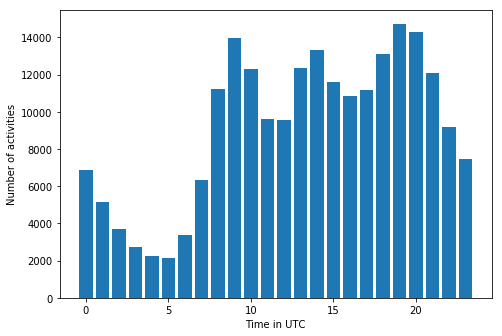

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size().index, df_nyc_w_weather['timestamp_loc'].groupby(df_nyc_w_weather['timestamp_loc'].dt.hour).size())
ax.set_xlabel('Time in UTC')
ax.set_ylabel('Number of activities')
plt.show()

Next step is to plot a bar graph which is showing the weekday and the number of activities

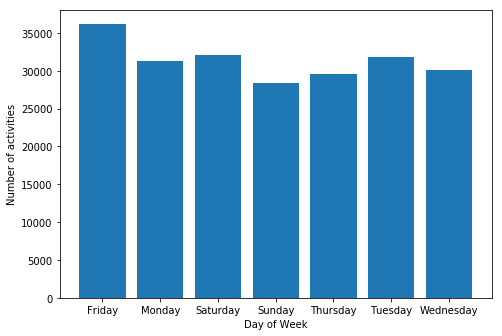

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_nyc_w_weather.groupby(df_nyc_w_weather['day_ow_bin']).size().index, df_nyc_w_weather['day_ow_bin'].groupby(df_nyc_w_weather['day_ow_bin']).size())
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of activities')
plt.show()

Next step is to remove more unnecessary data before training the model

In [16]:
drop_col_list = ['venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'utcTimestamp', 'timestamp', 'UTCdate', 'UTCtime', 'timestamp_loc']
df_nyc_w_weather_ml = df_nyc_w_weather.drop(columns = drop_col_list, axis=1)

In the following, the model will be trained

In [17]:
LE = preprocessing.LabelEncoder()
df_nyc_w_weather_ml = df_nyc_w_weather_ml.apply(LE.fit_transform)

In the next step the model is run 7 times to select the best number of clusters

In [18]:
cost = []
for attempts in list(range(1,8)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1925028.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7890, cost: 1836219.0
Run 1, iteration: 2/100, moves: 982, cost: 1836219.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9659, cost: 1774833.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7616, cost: 1727685.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7431, cost: 1701186.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5687, cost: 1687923.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5869, cost: 1672358.0


Visualize the cost vs. the number of clusters

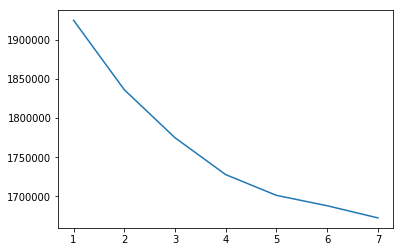

In [19]:
y = np.array([i for i in range(1, 8, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

# Adapt Data

As the result is not very good, the data is futher optimized by rounding the temperature and the sunHour to integer

In [20]:
drop_col_list = ['venueId', 'venueCategoryId', 'latitude', 'longitude', 'timezoneOffset', 'utcTimestamp', 'timestamp', 'UTCdate', 'UTCtime', 'timestamp_loc', 'userId', 'cloudcover', 'humidity', 'precipMM', 'pressure']

df_nyc_w_weather_advanced = df_nyc_w_weather.drop(columns = drop_col_list, axis=1)
df_nyc_w_weather_advanced[['sunHour']] = df_nyc_w_weather_advanced[['sunHour']].astype('float').round(decimals=0)
df_nyc_w_weather_advanced = df_nyc_w_weather_advanced.astype({'tempC': 'int16', 'sunHour': 'int16'})
df_nyc_w_weather_advanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219501 entries, 0 to 219500
Data columns (total 6 columns):
venueCategory    219501 non-null object
tempC            219501 non-null int16
sunHour          219501 non-null int16
season_bin       219501 non-null object
day_bin          219501 non-null object
day_ow_bin       219501 non-null object
dtypes: int16(2), object(4)
memory usage: 9.2+ MB


Next attempt to check the model, this time with k from 1 up to 11

In [21]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,11)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1046202.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 961471.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 898051.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 853886.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 830573.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 821123.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 811342.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, it

Visualization of the respective model

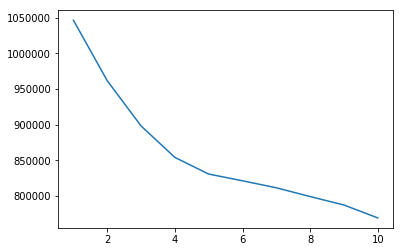

In [22]:
y = np.array([i for i in range(1, 11, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

As the result didn't get any better, the model is being further optimized by reducing the unique categories that are included in the dataset to the top 34 categories with the most activities

In [23]:
drop_columns = ['Bar', 'Food & Drink Shop', 'Clothing Store', 'Coffee Shop', 'Pizza Place', 'American Restaurant', 'Deli / Bodega', 'Gym / Fitness Center', 'Italian Restaurant',
               'Park', 'Chinese Restaurant', 'Fast Food Restaurant', 'Sandwich Place', 'Mexican Restaurant', 'Bakery','Café','Diner', 'General Entertainment', 'Burger Joint',
               'Sushi Restaurant', 'Theater', 'Art Gallery', 'Food Truck', 'Athletic & Sport', 'Ice Cream Shop', 'Spa / Massage', 'Bagel Shop', 'Donut Shop', 'Asian Restaurant',
               'French Restaurant', 'Thai Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Indian Restaurant']

df_nyc_w_weather_advanced = df_nyc_w_weather_advanced[df_nyc_w_weather_advanced['venueCategory'].isin(drop_columns)]
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
df_nyc_w_weather_advanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81472 entries, 2 to 219500
Data columns (total 6 columns):
venueCategory    81472 non-null object
tempC            81472 non-null int16
sunHour          81472 non-null int16
season_bin       81472 non-null object
day_bin          81472 non-null object
day_ow_bin       81472 non-null object
dtypes: int16(2), object(4)
memory usage: 3.4+ MB


To check if the perfect elbow point might be somewhere else the number of attempts is increased to 1 to 31

In [24]:
cost = []
for attempts in list(range(1,31)):
    km_cao = KModes(n_clusters=attempts, init = "Cao", n_init = 1, verbose=1)
    fitClusters_cao = km_cao.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_cao.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 342371.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 319273.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 306020.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 295666.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 290589.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 772, cost: 283679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, i

Visualization of the result

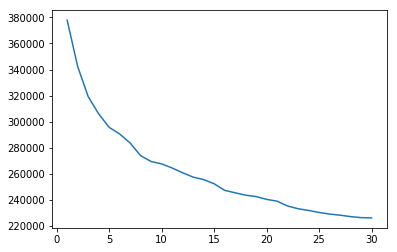

In [25]:
y = np.array([i for i in range(1, 31, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

To compare the result another algorithm is used (switch from CAO to HUANG)

In [26]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,31)):
    km_Huang = KModes(n_clusters=attempts, init = "Huang", n_init = 1, verbose=1)
    fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_Huang.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8651, cost: 342945.0
Run 1, iteration: 2/100, moves: 336, cost: 342945.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10451, cost: 322454.0
Run 1, iteration: 2/100, moves: 1698, cost: 322454.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 29692, cost: 311984.0
Run 1, iteration: 2/100, moves: 7039, cost: 311984.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 22285, cost: 305640.0
Run 1, iteration: 2/100, moves: 143, cost: 305640.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14603, cost: 

Visualization of the result

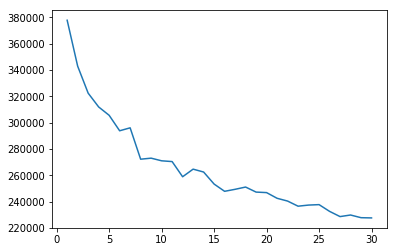

In [27]:
y = np.array([i for i in range(1, 31, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

As there the result is the best so far, this algorithm is choosen and started again with k (1, 11) to get a more zoomed overview

In [28]:
df_nyc_w_weather_ml_advanced = df_nyc_w_weather_advanced.apply(LE.fit_transform)
cost = []

for attempts in list(range(1,11)):
    km_Huang = KModes(n_clusters=attempts, init = "Huang", n_init = 1, verbose=1)
    fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))
    cost.append(km_Huang.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 377815.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15220, cost: 341069.0
Run 1, iteration: 2/100, moves: 404, cost: 341069.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7326, cost: 319153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 28456, cost: 302581.0
Run 1, iteration: 2/100, moves: 7960, cost: 302581.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 22425, cost: 296567.0
Run 1, iteration: 2/100, moves: 755, cost: 296567.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16839, cost: 293666.0
Run 1, iteration: 2/100, moves: 42, cost: 29

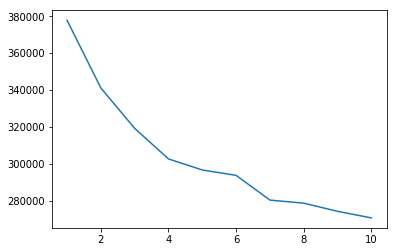

In [29]:
y = np.array([i for i in range(1, 11, 1)])

plt.plot(y, cost)
plt.xlabel='Cost'
plt.ylabel='K'
plt.ylim()
plt.show()

Best Algorithm is Huang and best K is 8

Run again with Parameters Huang as Mode and 8 as K

In [30]:
k = 8
km_Huang = KModes(n_clusters=k, init = "Huang", n_init = 1, verbose=1)
fitClusters_Huang = km_Huang.fit_predict(df_nyc_w_weather_ml_advanced.reset_index(drop=True))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 23187, cost: 284027.0
Run 1, iteration: 2/100, moves: 595, cost: 284027.0


attach the predicted clusters to the original dataframe

In [31]:
clusterDf = pd.DataFrame(fitClusters_Huang)
clusterDf.columns = ['cluster_predicted']
clusterDf = pd.concat([df_nyc_w_weather_advanced.reset_index(), clusterDf], axis=1).reset_index()
clusterDf = clusterDf.drop(['index'], axis=1)

split each cluster into a own variable

In [32]:
clusterDf_0 = clusterDf.loc[clusterDf['cluster_predicted'] == 0]
clusterDf_1 = clusterDf.loc[clusterDf['cluster_predicted'] == 1]
clusterDf_2 = clusterDf.loc[clusterDf['cluster_predicted'] == 2]
clusterDf_3 = clusterDf.loc[clusterDf['cluster_predicted'] == 3]
clusterDf_4 = clusterDf.loc[clusterDf['cluster_predicted'] == 4]
clusterDf_5 = clusterDf.loc[clusterDf['cluster_predicted'] == 5]
clusterDf_6 = clusterDf.loc[clusterDf['cluster_predicted'] == 6]
clusterDf_7 = clusterDf.loc[clusterDf['cluster_predicted'] == 7]

Plot the data to explore possible correlations (Total Number of activities vs. Part of the day)

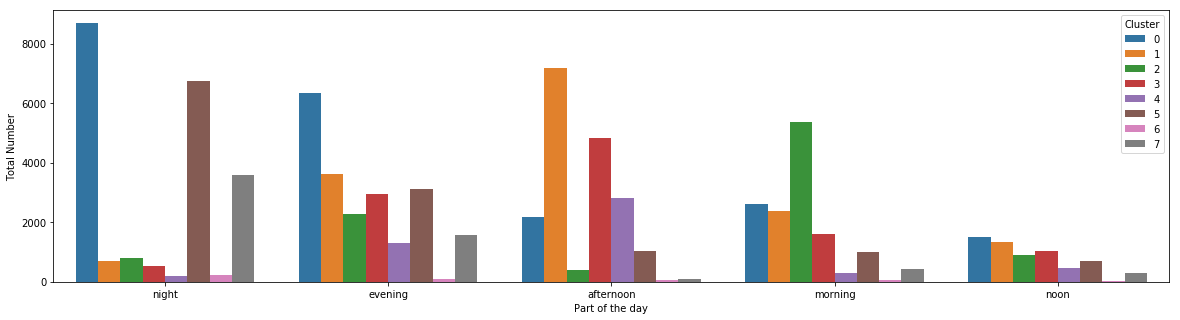

In [33]:
plt.subplots(figsize = (20,5))
ax =sns.countplot(x=clusterDf['day_bin'],order=clusterDf['day_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
ax.set(xlabel='Part of the day', ylabel='Total Number')
ax.legend(title='Cluster')
plt.show()

Plot the data to explore possible correlations (Total Number of activities vs. Temperature)

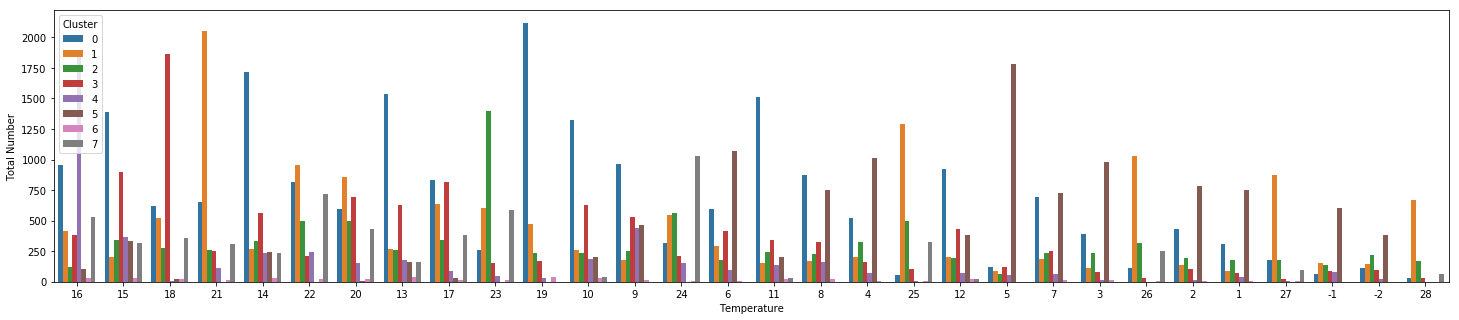

In [34]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(x=clusterDf['tempC'],order=clusterDf['tempC'].value_counts().nlargest(30).index,hue=clusterDf['cluster_predicted'])
ax.set(xlabel='Temperature', ylabel='Total Number')
ax.legend(title='Cluster')
plt.show()

Plot the data to explore possible correlations (Total Number of activities vs. Season)

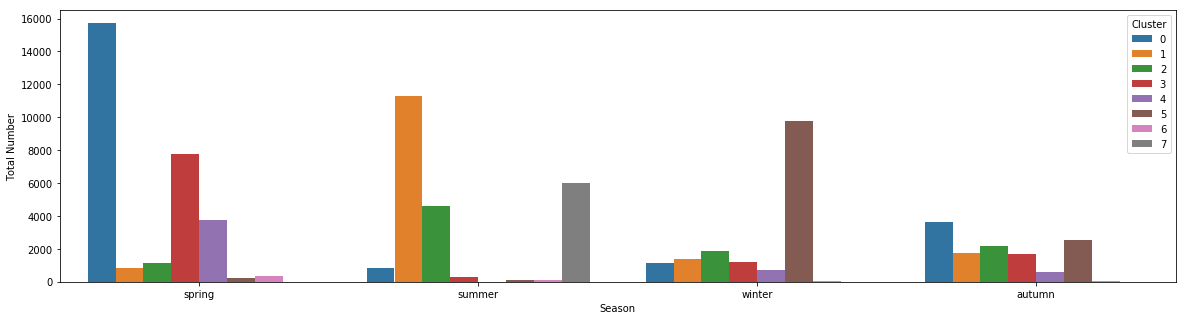

In [35]:
plt.subplots(figsize = (20,5))
ax = sns.countplot(x=clusterDf['season_bin'],order=clusterDf['season_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
ax.set(xlabel='Season', ylabel='Total Number')
ax.legend(title='Cluster')
plt.show()

Plot the data to explore possible correlations (Total Number of activities vs. Category)

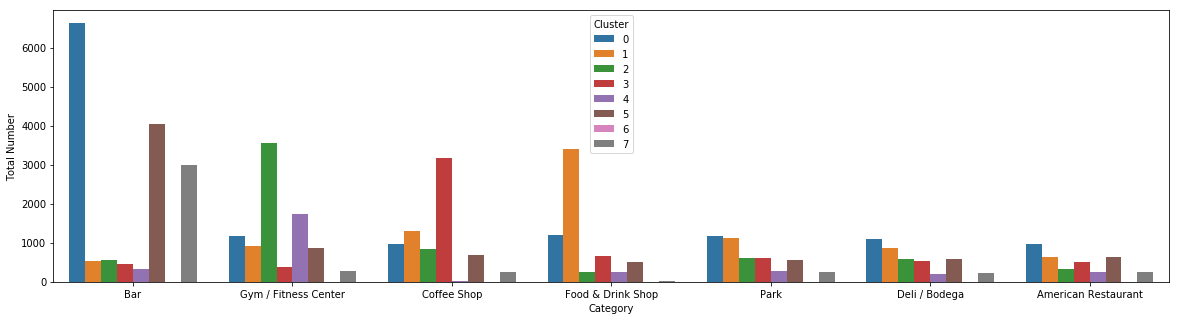

In [36]:
plt.subplots(figsize = (20,5))
ax = sns.countplot(x=clusterDf['venueCategory'], order=clusterDf['venueCategory'].value_counts().nlargest(7).index,hue=clusterDf['cluster_predicted'])
ax.set(xlabel='Category', ylabel='Total Number')
ax.legend(title='Cluster')
plt.show()

Plot the data to explore possible correlations (Total Number of activities vs. Day of the week)

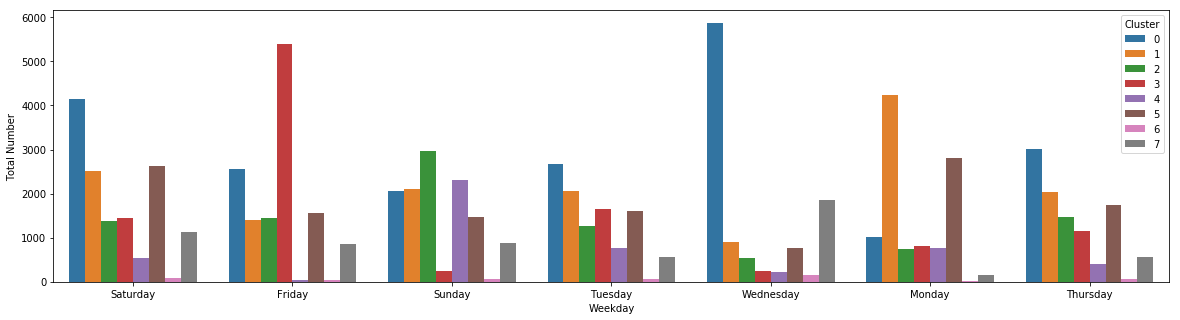

In [37]:
plt.subplots(figsize = (20,5))
ax = sns.countplot(x=clusterDf['day_ow_bin'],order=clusterDf['day_ow_bin'].value_counts().index,hue=clusterDf['cluster_predicted'])
ax.set(xlabel='Weekday', ylabel='Total Number')
ax.legend(title='Cluster')
plt.show()

# Prediction

After clustering the data I try to predict possible activities based on the above selected criteria (e.g. temperature, time of the day, season, day of the week)

The LabelEncoder is used to prepare the data for importing to the Decision Tree Algorithm

In [38]:
#preprocessing
#X = df_nyc_w_weather_advanced[['tempC', 'sunHour', 'season_bin', 'day_bin', 'day_ow_bin']].values

X = df_nyc_w_weather_advanced[['tempC', 'day_bin', 'day_ow_bin']].values

#le_season_bin = preprocessing.LabelEncoder()
#X[:,1] = le_season_bin.fit_transform(df_nyc_w_weather_advanced['season_bin'])

le_day_bin = preprocessing.LabelEncoder()
X[:,1] = le_day_bin.fit_transform(df_nyc_w_weather_advanced['day_bin'])

le_day_ow_bin = preprocessing.LabelEncoder()
X[:,2] = le_day_ow_bin.fit_transform(df_nyc_w_weather_advanced['day_ow_bin'])

y = df_nyc_w_weather_advanced['venueCategory']
X

array([[8, 3, 5],
       [8, 3, 5],
       [8, 3, 5],
       ...,
       [4, 3, 0],
       [4, 3, 0],
       [4, 3, 0]], dtype=object)

The data set will be splited between training and test data set

In [39]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=1)
print('X_trainset: ' + str(X_trainset.shape))
print('y_trainset: ' + str(y_trainset.shape))
print('X_testset: ' + str(X_testset.shape))
print('y_testset: ' + str(y_testset.shape))

X_trainset: (57030, 3)
y_trainset: (57030,)
X_testset: (24442, 3)
y_testset: (24442,)


The model is trained in the next step

In [40]:
travelTree = DecisionTreeClassifier(criterion="entropy", max_depth=4)
travelTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

A prediction is made with the test data

In [41]:
predTravelTree = travelTree.predict(X_testset)

The accuracy is calculated

In [42]:
print("Accuracy: ", metrics.accuracy_score(y_testset, predTravelTree))

Accuracy:  0.23320513869568776


As the accuracy of the decision tree algorithm was not very good, the SVM algorithm is used in a next step

The procedure is the same (train the dataset, predict the values and caculate the error)

In [43]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_trainset, y_trainset) 
yhat = clf.predict(X_testset)

from sklearn.metrics import f1_score
f1_score(y_testset, yhat, average='weighted') 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.06000108955388997

For a last comparision the KNN algorithm is tried

- First of all, all category data is transformed to readable data
- The model is trained for 1 to 25 nighbour clusters
- The model is tested with the test data and the accuracy is calculated

In [44]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

season_bin_encoded=le.fit_transform(df_nyc_w_weather_advanced['season_bin'])
day_bin_encoded=le.fit_transform(df_nyc_w_weather_advanced['day_bin'])
day_ow_bin=le.fit_transform(df_nyc_w_weather_advanced['day_bin'])
label = le.fit_transform(df_nyc_w_weather_advanced['venueCategory'])

features=list(zip(season_bin_encoded,day_bin_encoded,day_ow_bin))

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

from sklearn.neighbors import KNeighborsClassifier

for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print("K: "+ str(i) + "Accuracy:",metrics.accuracy_score(y_test, y_pred))
                               

K: 1Accuracy: 0.1132862841362381
K: 2Accuracy: 0.1870512427124885
K: 3Accuracy: 0.1811598649892605
K: 4Accuracy: 0.1674746854863455
K: 5Accuracy: 0.17508438171218166
K: 6Accuracy: 0.19533599263577783
K: 7Accuracy: 0.2012887388769561
K: 8Accuracy: 0.2022092666462105
K: 9Accuracy: 0.19011966861000307
K: 10Accuracy: 0.19324946302546794
K: 11Accuracy: 0.19981589444614914
K: 12Accuracy: 0.18465787051242713
K: 13Accuracy: 0.18864682417919607
K: 14Accuracy: 0.1942313593126726
K: 15Accuracy: 0.1984657870512427
K: 16Accuracy: 0.19822031297944154
K: 17Accuracy: 0.19914084074869592
K: 18Accuracy: 0.20012273703590058
K: 19Accuracy: 0.20245474071801167
K: 20Accuracy: 0.20245474071801167
K: 21Accuracy: 0.1992635777845965
K: 22Accuracy: 0.19613378336913165
K: 23Accuracy: 0.19944768333844737
K: 24Accuracy: 0.19944768333844737


# Outlook

Improve the model by improving the used algorithm and the features that are used to train the algorithm